In [46]:
import xarray as xr

from oas_dev.util.Nd.sizedist_class_v2 import SizedistributionStation
from sectional_v2.util.eusaar_data.eusaar_noresm import compute_all_subsets_percs_flag, get_all_distc_noresm
from useful_scit.util.make_folders import make_folders

## Cases:

In [47]:
# Case names:
cases_sec = ['SECTv21_ctrl_koagD']#, 'SECTv21_ctrl']#,'SECTv11_redSOA_LVnuc','SECTv11_incBVOC']#'PD_SECT_CHC7_diur_ricc']#, 'PD_SECT_CHC7_diurnal']# , 'PD_SECT_CHC7_diur_ricc_incC']
cases_orig = ['noSECTv21_default_dd','noSECTv21_ox_ricc_dd']#'noSECTv11_ctrl']#,'PD_noSECT_nudgeERA_eq20']#'Original eq.20']  # , 'Original eq.18','Original eq.20, 1.5xBVOC','Original eq.20, rednuc']
cases = cases_sec + cases_orig

## Settings

In [49]:

from_t = '2008-01-01'
to_t = '2010-01-01'
nr_of_bins = 5
maxDiameter = 39.6  # 23.6 #e-9
minDiameter = 5.0  # e-9
time_resolution = 'hour'
history_field='.h1.'

### EUSAAR subset:

In [51]:
year_subset='BOTH'

## Load datasets:

### Models

In [52]:
dic_finish = {}
for case_name in cases:
    #_ds = dic_mod_all[case_name]
    ds = get_all_distc_noresm(case_name, from_t, to_t)
    dic_finish[case_name] = ds

## make sectional not sum of mode and sectional

for case in cases_sec:
    _ds = dic_finish[case]
    _ds['dNdlogD_mod_mod'] = _ds['dNdlogD_mod'].where(_ds['diameter']>=39.6, other=0)
    _ds['dNdlogD'] = _ds['dNdlogD_sec'] + _ds['dNdlogD_mod_mod']
    dic_finish[case] = _ds

In [53]:
dic_finish
import numpy as np
for key in cases:
    dic_finish[key]['dNdlog10dp'] = dic_finish[key]['dNdlogD']*np.log(10)

In [54]:
dic_finish['SECTv21_ctrl_koagD']

<xarray.Dataset>
Dimensions:         (diameter: 61, lev: 5, percentile: 5, station: 24, subset: 7)
Coordinates:
    quantile        (percentile) float64 ...
  * station         (station) object 'ASP' 'BIR' 'PAL' ... 'JFJ' 'BEO' 'CMN'
  * diameter        (diameter) float64 1.0 1.1 1.3 1.4 ... 794.3 891.2 1e+03
  * percentile      (percentile) object '5th percentile' ... '95th percentile'
  * lev             (lev) float64 912.6 936.2 957.5 976.3 992.6
  * subset          (subset) object 'NIG' 'AUT' 'SPR' 'TOT' 'WIN' 'SUM' 'DAY'
Data variables:
    dNdlogD_mod     (subset, percentile, station, lev, diameter) float64 ...
    dNdlogD_sec     (subset, percentile, station, lev, diameter) float64 ...
    dNdlogD         (subset, percentile, station, lev, diameter) float64 4.885e-10 ... 17.1
    dNdlog10dp      (subset, percentile, station, lev, diameter) float64 1.125e-09 ... 39.36
    dNdlog10dp_mod  (subset, percentile, station, lev, diameter) float64 ...
    dNdlog10dp_sec  (subset, percentile, station, lev, diameter) float64 ...

### Eusaar:

In [55]:
# %load_ext autoreload
# %autoreload 2
import numpy as np
from sectional_v2.util.eusaar_data import  distc_var  # import load_var_as_dtframe
import matplotlib.pyplot as plt
from useful_scit.plot import get_cmap_dic

In [56]:
ds_eusaar = distc_var.get_distc_xarray_all(from_nc=True)

In [57]:

# select bottom layer
for case in dic_finish.keys():
    ds = dic_finish[case]

    if 'lev' in ds.coords:
        dic_finish[case] = ds.isel(lev=-1)

In [58]:

ds_eusaar

<xarray.Dataset>
Dimensions:     (diameter: 61, percentile: 5, station: 24, subset: 8, year: 3)
Coordinates:
  * diameter    (diameter) float64 1.0 1.1 1.3 1.4 ... 708.0 794.3 891.2 1e+03
  * subset      (subset) object 'DAY' 'SPR' 'SUM' 'NIG' 'ECH' 'TOT' 'WIN' 'AUT'
  * station     (station) object 'KPO' 'BEO' 'MHD' 'PLA' ... 'FKL' 'SMR' 'JFJ'
  * percentile  (percentile) object '5th percentile' ... '95th percentile'
  * year        (year) object 'BOTH' '2008' '2009'
Data variables:
    dNdlog10dp  (year, subset, station, percentile, diameter) float64 ...

In [59]:
ds_eusaar = ds_eusaar.sel(year=year_subset)

In [60]:

dic_finish['eusaar'] = ds_eusaar

### Various functions:

In [61]:

from sectional_v2.constants import collocate_locations, paths_plotsave, collocate_locations, collocate_locations

In [62]:

coll_ltr = collocate_locations.transpose()

In [63]:

from useful_scit.util.pd_fix import pd_custom_sort_values
#pd_custom_sort_values(coll_ltr, sorter, dall_c)

#coll_ltr

In [64]:

dall_c = "Dall'Osto 2018 categories"
sorter = ['North','Center','South (spring)', 'South (winter)', 'Overlap']

def make_new_cat():
    """
    Make new category
    """
    coll_ltr = collocate_locations.transpose()

    td = {
        'Low altitude sites (less than 1000 m a.s.l.)': 'LA',
        'High altitude sites (over 1000 m a.s.l.)': 'HA'
    }
    coll_ltr['AC'] = coll_ltr['Altitude category'].apply(lambda x: td[x])

    coll_ltr['new_cat'] = coll_ltr['AC'] + ': ' + coll_ltr['Region']
    coll_ltr = coll_ltr.sort_values('new_cat', ascending=False)
    return coll_ltr

def get_ordered_stations():
    coll_ltr = make_new_cat()
    coll_ltr=pd_custom_sort_values(coll_ltr, sorter, dall_c)
    return coll_ltr.index
list(get_ordered_stations())

['ZEP',
 'MHD',
 'ASP',
 'SMR',
 'PAL',
 'OBK',
 'VHL',
 'MPZ',
 'WAL',
 'BOS',
 'HPB',
 'KPO',
 'JRC',
 'FKL',
 'JFJ',
 'SSL',
 'ZSF',
 'CMN',
 'BEO',
 'PDD',
 'PLA',
 'BIR',
 'HWL',
 'CBW']

In [65]:

coll_ltr = collocate_locations.transpose()

In [66]:
from sectional_v2.data_info import get_nice_name_case

In [68]:
from useful_scit.plot import get_cmap_dic
from sectional_v2.constants import collocate_locations, paths_plotsave, collocate_locations, collocate_locations
from sectional_v2.util.plot.colors import get_case_col


def plot_grid(dic_finish, subs = 'TOT', st_ls=None, name='all_stations', ylim=[5,8.8e3],
              yscale='linear', plot_sec=True,nr_col=4, figsize=None, ylim_ZEP=[0,500]):

    colors_source = get_cmap_dic(dic_finish.keys())
    colors_source['EUSAAR']='k'

    dic_ds = dic_finish
    t_cs =dic_ds[ list(dic_ds.keys())[0]]
    st_ls =list(get_ordered_stations())
    #    st_ls = list(loc_tr[loc_tr['Region']==reg].index)
    print(list(st_ls))
    if len(st_ls)>nr_col:
        nr_row = int(np.ceil(len(st_ls)/nr_col))
    else:
        nr_row=1
        nr_col=len(st_ls)
    
    if figsize is None:
        figsize = [10 / 4 * nr_col, 10 / 6 * nr_row]

    fig, axs = plt.subplots(nr_row, nr_col , sharex=True,sharey=True, figsize=figsize )
    axs_nf = axs
    if nr_row>1: axs = axs.flatten()
    for station, ax in zip(st_ls, axs):
        lines=[]
        labels= []
        for key in dic_finish.keys():
            _ds = dic_finish[key]
            #if 'dNdlog10dp_sec' in _ds:
            #    plt_perc(dic_finish[key]['dNdlog10dp_sec'], station, key,
            #            color=get_case_col(key),
            #            ax=ax,
            #            subs=subs, percs=[16,84], yscale=yscale, ylim=ylim)
            ##    plt_perc(dic_finish[key]['dNdlog10dp_mod'], station, key,
            #            color=get_case_col(key),
            #            ax=ax,
            #            subs=subs, percs=[16,84], yscale=yscale, ylim=ylim)
            #else:
                
            plt_perc(dic_finish[key]['dNdlog10dp'], station, key,
                        color=get_case_col(key),
                        ax=ax,
                        subs=subs, percs=[16,84], yscale=yscale, ylim=ylim)
        for key in dic_finish.keys():
            _ds = dic_finish[key]
            #if 'dNdlog10dp_sec' in _ds:
            #    line =plt_median(dic_finish[key]['dNdlog10dp_sec'], station, key,
            #            color=get_case_col(key),
            #            ax=ax,
            #            subs=subs, percs=[16,84], yscale=yscale, ylim=ylim)
            #    line =plt_median(dic_finish[key]['dNdlog10dp_mod'], station, key,
            #            color=get_case_col(key),
            #            ax=ax,
            #            subs=subs, percs=[16,84], yscale=yscale, ylim=ylim)

            #else:
            if 'dNdlog10dp_sec' in _ds:
                line =plt_median(dic_finish[key]['dNdlog10dp_sec'].where(dic_finish[key]['dNdlog10dp_sec']>0), station, key,
                        color=get_case_col(key),
                        ax=ax,
                        subs=subs, percs=[16,84], yscale=yscale, ylim=ylim,
                                plt_kwargs = {'linestyle':'dashed'})

            line =plt_median(dic_finish[key]['dNdlog10dp'], station, key,
                        color=get_case_col(key),
                        ax=ax,
                        subs=subs, percs=[16,84], yscale=yscale, ylim=ylim)
                
                
            
            lines = lines+line
            labels.append(get_nice_name_case(key))
        if station=='ZEP':
            axins = insert_ZEP(ax)
            for key in dic_finish.keys():
                plt_perc(dic_finish[key]['dNdlog10dp'], station, key,
                        color=get_case_col(key),
                        ax=axins,
                        subs=subs, percs=[16,84], yscale=yscale, ylim=ylim_ZEP)
            for key in dic_finish.keys():    
                plt_median(dic_finish[key]['dNdlog10dp'], station, key,
                        color=get_case_col(key),
                        ax=axins,
                        subs=subs, percs=[16,84], yscale=yscale, ylim=ylim_ZEP)
                if 'dNdlog10dp_sec' in _ds:
                    
                    plt_median(dic_finish[key]['dNdlog10dp_sec'], station, key,
                        color=get_case_col(key),
                        ax=axins,
                        subs=subs, percs=[16,84], yscale=yscale, ylim=ylim_ZEP)

            ax.indicate_inset_zoom(axins,edgecolor='r',)
            fix_ins(axins)
        if subs=='TOT':
            cat = coll_ltr.loc[station, dall_c]
            ax.set_title(station)#+' '+cat)
        else:
            cat = coll_ltr.loc[station, dall_c]
            ax.set_title(station+' '+ subs)#+', '+cat)
        ax.grid(True)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis=u'y', which=u'both',length=0)

    if nr_row>1:
        for ii in range(nr_row):
            for jj in range(nr_col):
                if ii !=nr_row-1:
                    axs_nf[ii,jj].set_xlabel('')
                if jj!=0:
                    axs_nf[ii,jj].set_ylabel('')
                else:
                    axs_nf[ii,jj].set_ylabel('dN/dlog$_{10}$D [cm$^{-3}$]')
                    
                    
                    

    fig.tight_layout()
    lgn = fig.legend(lines, labels, bbox_to_anchor=(0, 1., 1, 0.5),  # (0, -0.04, 1., .1),
                     loc='lower center', ncol=4,
                     # mode="expand",
                     borderaxespad=0., fontsize=11, frameon=False)  # bbox_to_anchor=(0, 1., 1, 0.5))

    #fig.legend(lines, labels, bbox_to_anchor=(0,1.,1,0.5),#(0, -0.04, 1., .1), 
    #       loc='lower center', ncol=4, 
    #       #mode="expand", 
    #       borderaxespad=0., fontsize=11, frameon=False)# bbox_to_anchor=(0, 1., 1, 0.5))


    fn = paths_plotsave['eusaar'] + '/sizedist/%s_overview_yscale_%s_sec%s_%s.'%(name.replace(' ','-'),yscale, plot_sec, subs)
    print(fn)
    make_folders(fn)
    plt.savefig(fn+'png', bbox_extra_artists=(lgn,), bbox_inches='tight')
    plt.savefig(fn+'pdf', bbox_extra_artists=(lgn,), bbox_inches='tight')
    plt.show()

In [69]:
def plt_median(ds, station, label, percs=[5, 95], ax=None, ylim=[1, 8e3], xlim=[5, 5e2],
                    yscale='linear', color='k', subs='TOT', year='2008', plt_kwargs={}):
    if ax is None:
        fig, ax= plt.subplots(1)
    da = ds.sel(subset=subs)
    _da50 = da.sel(station=station, percentile='50th percentile')#
    lines = _da50.plot(yscale=yscale,xscale='log', label=label+', %s'%station,
                       color=color , 
                       ax=ax,**plt_kwargs)
    return lines

def plt_perc(ds, station, label, percs=[5, 95], ax=None, ylim=[1, 8e3], xlim=[5, 5e2],
                    yscale='linear', color='k', subs='TOT', year='2008'):
    if ax is None:
        fig, ax= plt.subplots(1)
    da = ds.sel(subset=subs)

    _da95 = da.sel(station=station, percentile='%sth percentile'%percs[1])
    _da5 = da.sel(station=station, percentile='%sth percentile'%percs[0])
    ax.fill_between(da.diameter.values, _da5,_da95, alpha=.2 , color = color)

    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    return
             


In [70]:

def plt_median_perc(ds, station, label, percs=[5, 95], ax=None, ylim=[1, 8e3], xlim=[5, 5e2],
                    yscale='linear', color='k', subs='TOT', year='2008'):
    if ax is None:
        fig, ax= plt.subplots(1)
    da = ds.sel(subset=subs)
    _da50 = da.sel(station=station, percentile='50th percentile')#
    lines = _da50.plot(yscale=yscale,xscale='log', label=label+', %s'%station,color=color , ax=ax)
    _da95 = da.sel(station=station, percentile='%sth percentile'%percs[1])
    _da5 = da.sel(station=station, percentile='%sth percentile'%percs[0])
    ax.fill_between(da.diameter.values, _da5,_da95, alpha=.2 , color = color)

    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    return lines

In [71]:
        
def insert_ZEP(ax):
    axins = ax.inset_axes([0.23, 0.2, 0.67, 0.67])#zoomed_inset_axes(ax, zoom=1, loc='upper right')
    return axins
def fix_ins(axins):
    axins.set_xticklabels('')
    axins.grid(False)
    axins.yaxis.label.set_color('red')
    axins.tick_params(axis='y', colors='red')
    #    #axins.tick_params(axis=u'both', which=u'both',length=1)
    axins.spines['left'].set_color('r')
    axins.spines['right'].set_color('r')
    axins.spines['bottom'].set_color('r')
    axins.spines['top'].set_color('r')
    axins.set_title('')
    axins.set_xlabel('')
    axins.set_ylabel('')



In [72]:
dic_clean={}
_ds_eu = dic_finish['eusaar']
_ds_eu = _ds_eu.where(_ds_eu!=-1).drop('year')

In [73]:
for key in cases:

    dic_clean[key] = dic_finish[key].where(_ds_eu.notnull())
    if 'dNdlog10dp_sec' in dic_finish[key]:
        dic_clean[key]['dNdlog10dp_sec']=dic_finish[key]['dNdlog10dp_sec']
dic_clean['eusaar'] = _ds_eu

['ZEP', 'MHD', 'ASP', 'SMR', 'PAL', 'OBK', 'VHL', 'MPZ', 'WAL', 'BOS', 'HPB', 'KPO', 'JRC', 'FKL', 'JFJ', 'SSL', 'ZSF', 'CMN', 'BEO', 'PDD', 'PLA', 'BIR', 'HWL', 'CBW']
/home/ubuntu/mnts/nird/projects//Plots_OAS-DEV/eusaar//sizedist/all_stations_overview_yscale_linear_secTrue_TOT.


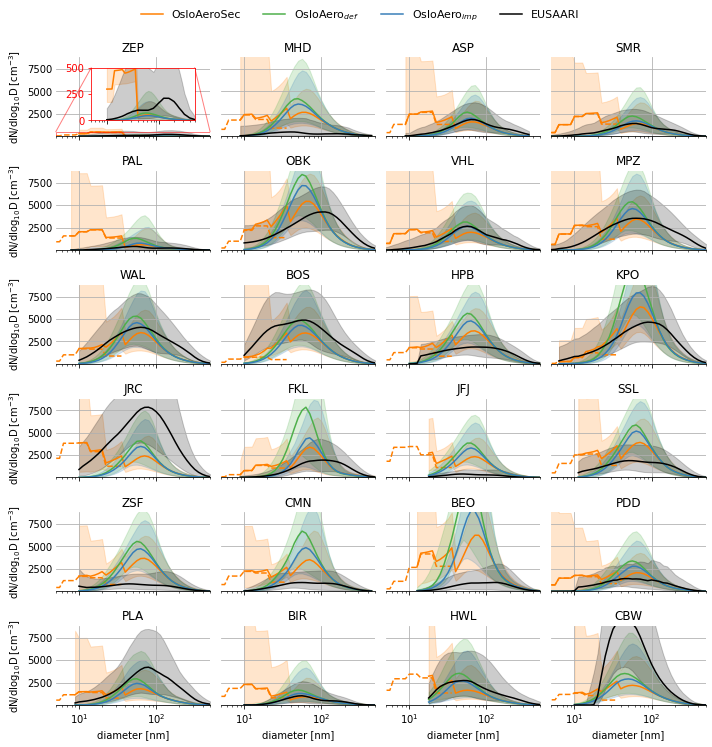

In [74]:

plot_grid(dic_clean)

['ZEP', 'MHD', 'ASP', 'SMR', 'PAL', 'OBK', 'VHL', 'MPZ', 'WAL', 'BOS', 'HPB', 'KPO', 'JRC', 'FKL', 'JFJ', 'SSL', 'ZSF', 'CMN', 'BEO', 'PDD', 'PLA', 'BIR', 'HWL', 'CBW']
/home/ubuntu/mnts/nird/projects//Plots_OAS-DEV/eusaar//sizedist/all_stations_overview_yscale_linear_secTrue_SUM.


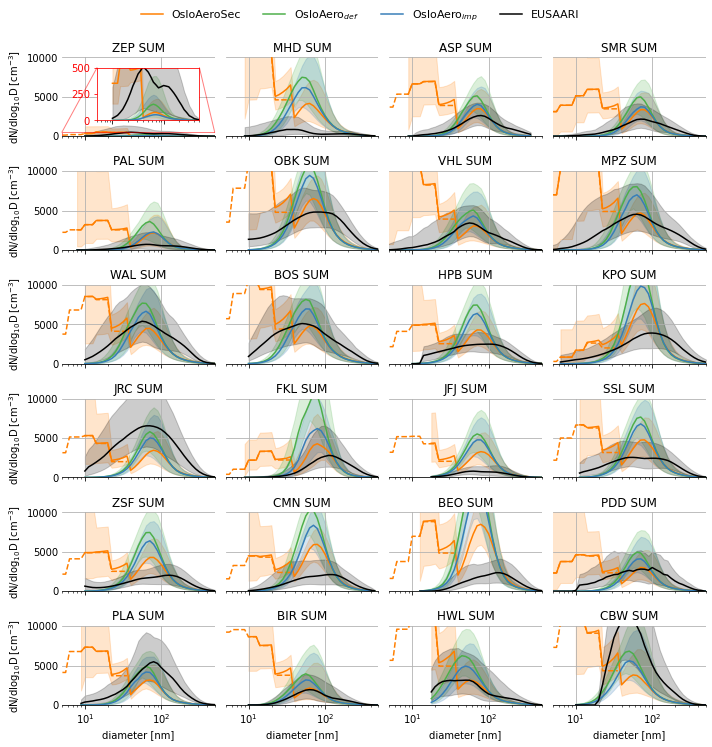

In [75]:
plot_grid(dic_clean,subs = 'SUM', ylim=[0,1e4])

['ZEP', 'MHD', 'ASP', 'SMR', 'PAL', 'OBK', 'VHL', 'MPZ', 'WAL', 'BOS', 'HPB', 'KPO', 'JRC', 'FKL', 'JFJ', 'SSL', 'ZSF', 'CMN', 'BEO', 'PDD', 'PLA', 'BIR', 'HWL', 'CBW']
/home/ubuntu/mnts/nird/projects//Plots_OAS-DEV/eusaar//sizedist/all_stations_overview_yscale_linear_secTrue_WIN.


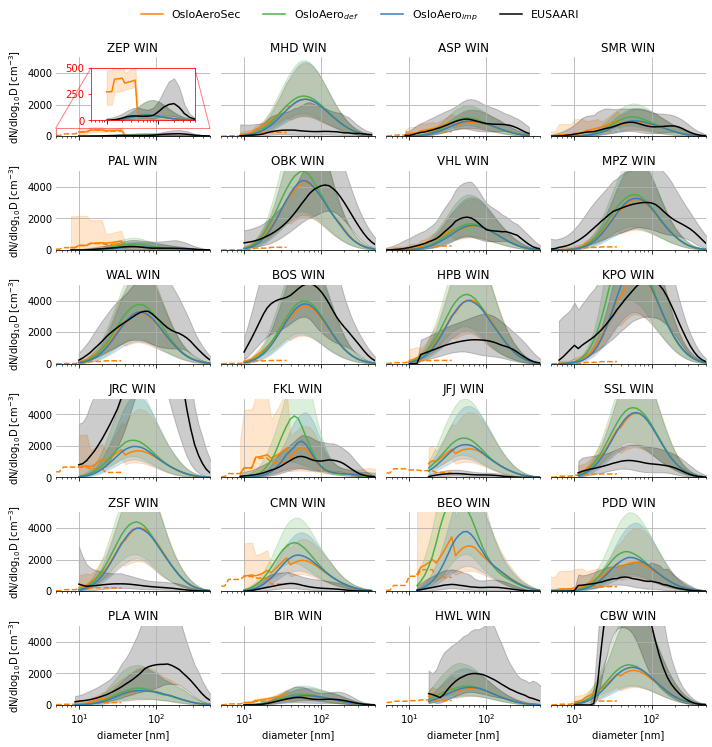

In [76]:
plot_grid(dic_clean,subs = 'WIN',  ylim=[0,5e3])

['ZEP', 'MHD', 'ASP', 'SMR', 'PAL', 'OBK', 'VHL', 'MPZ', 'WAL', 'BOS', 'HPB', 'KPO', 'JRC', 'FKL', 'JFJ', 'SSL', 'ZSF', 'CMN', 'BEO', 'PDD', 'PLA', 'BIR', 'HWL', 'CBW']
/home/ubuntu/mnts/nird/projects//Plots_OAS-DEV/eusaar//sizedist/all_stations_overview_yscale_linear_secTrue_SPR.


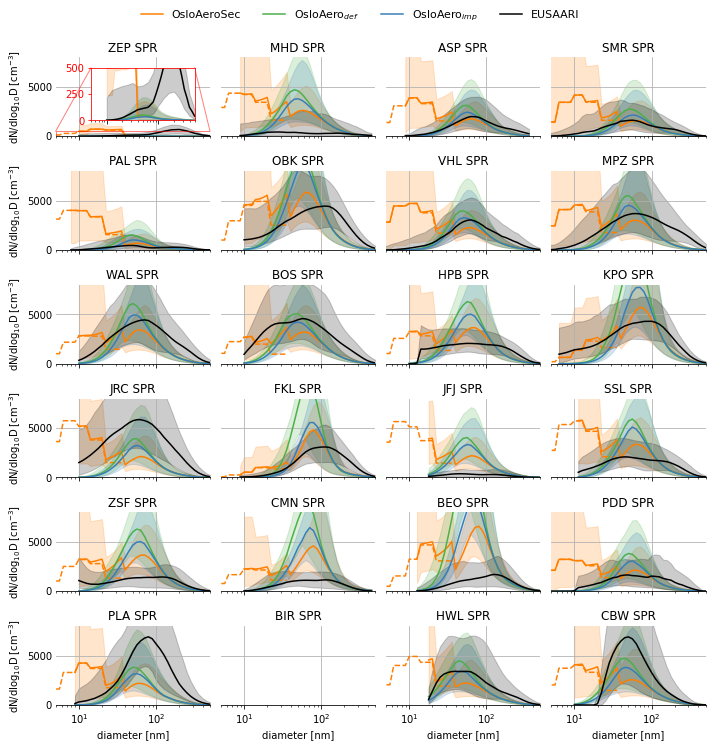

In [77]:
plot_grid(dic_clean,subs = 'SPR',  ylim=[0,8e3])

['ZEP', 'MHD', 'ASP', 'SMR', 'PAL', 'OBK', 'VHL', 'MPZ', 'WAL', 'BOS', 'HPB', 'KPO', 'JRC', 'FKL', 'JFJ', 'SSL', 'ZSF', 'CMN', 'BEO', 'PDD', 'PLA', 'BIR', 'HWL', 'CBW']
/home/ubuntu/mnts/nird/projects//Plots_OAS-DEV/eusaar//sizedist/all_stations_overview_yscale_linear_secTrue_AUT.


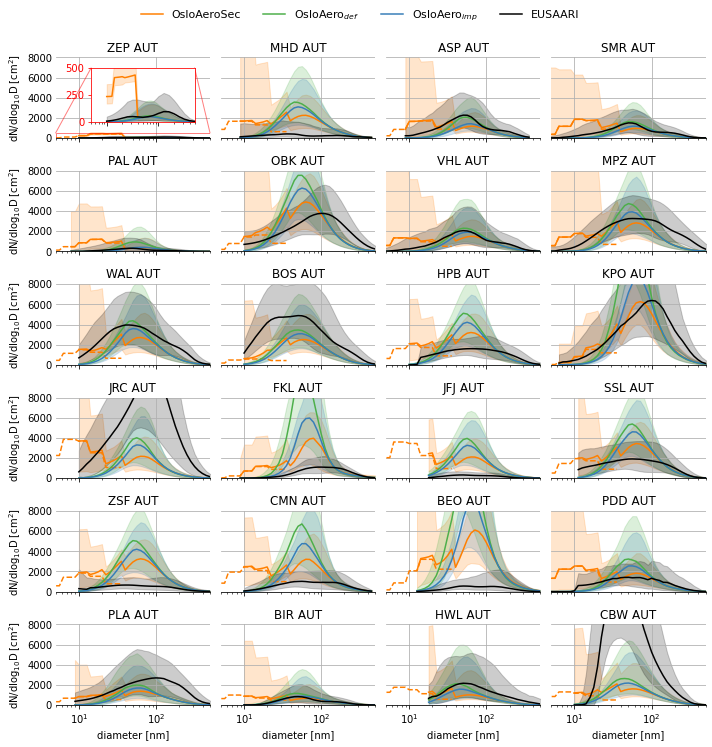

In [39]:
plot_grid(dic_clean,subs = 'AUT',  ylim=[0,8e3])

In [ ]:
plot_grid(dic_finish)

['ZEP', 'MHD', 'ASP', 'SMR', 'PAL', 'OBK', 'VHL', 'MPZ', 'WAL', 'BOS', 'HPB', 'KPO', 'JRC', 'FKL', 'JFJ', 'SSL', 'ZSF', 'CMN', 'BEO', 'PDD', 'PLA', 'BIR', 'HWL', 'CBW']
/home/ubuntu/mnts/nird/projects//Plots_OAS-DEV/eusaar//sizedist/all_stations_overview_yscale_linear_secTrue_TOT.


In [ ]:
plot_grid(dic_finish,subs = 'SUM', ylim=[0,1e4])

In [ ]:
plot_grid(dic_finish,subs = 'WIN',  ylim=[0,8e3])

In [ ]:
plot_grid(dic_finish,subs = 'SPR',  ylim=[0,8e3])

In [ ]:
plot_grid(dic_finish,subs = 'AUT',  ylim=[0,8e3])

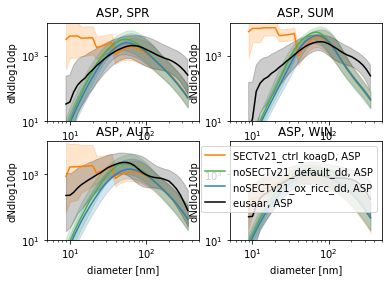

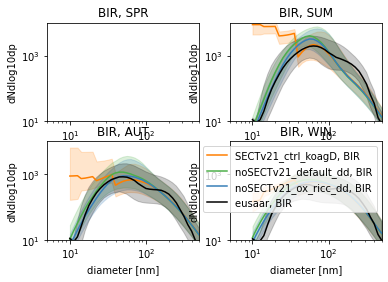

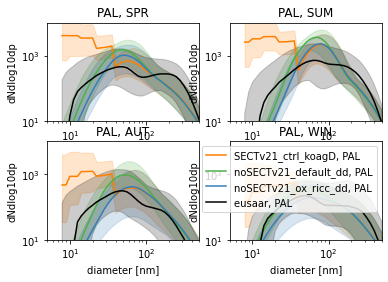

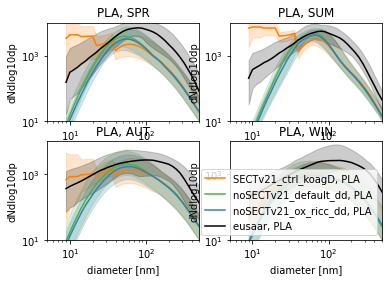

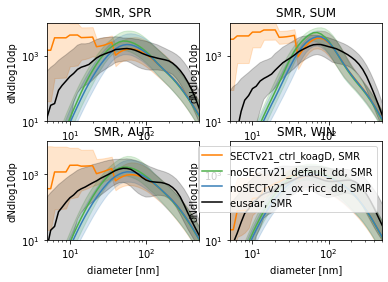

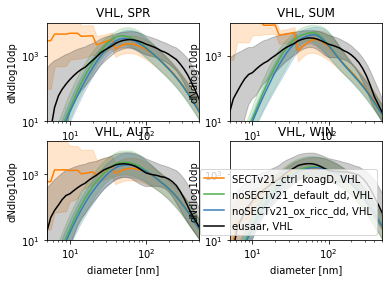

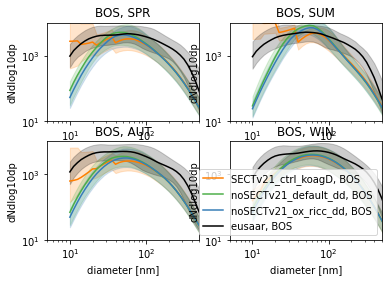

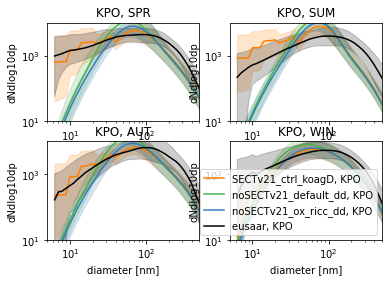

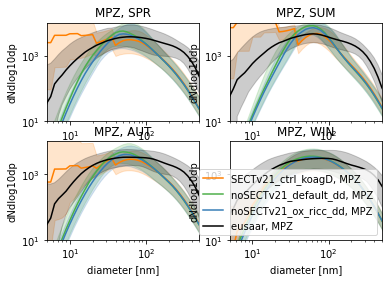

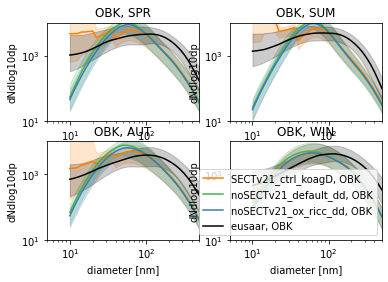

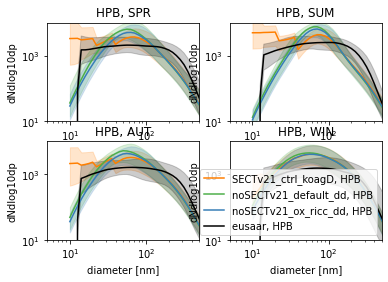

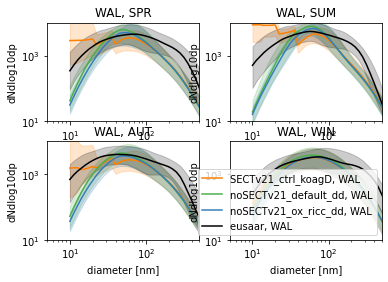

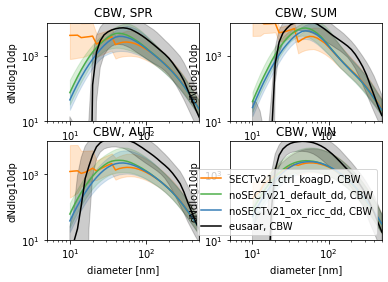

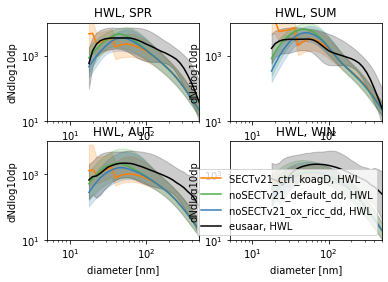

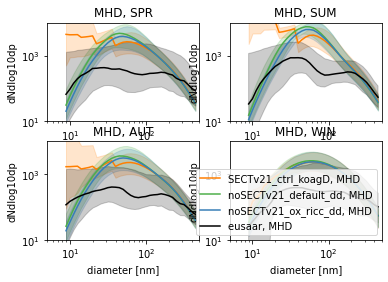

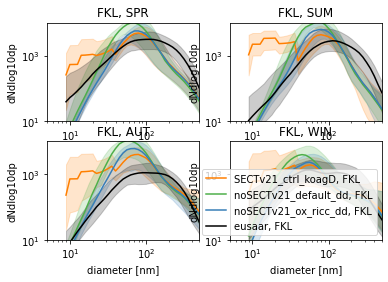

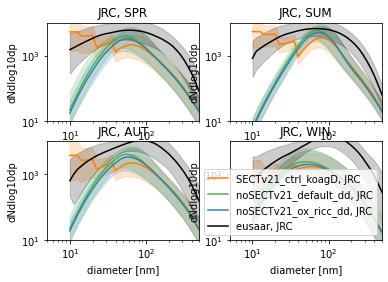

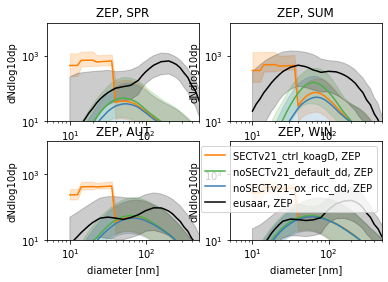

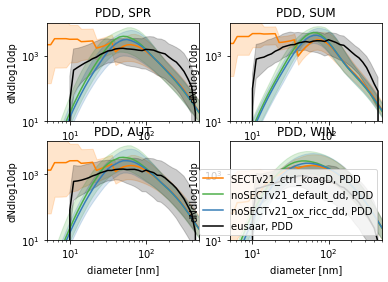

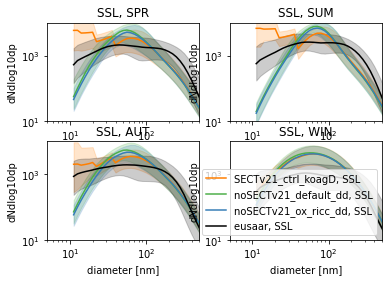

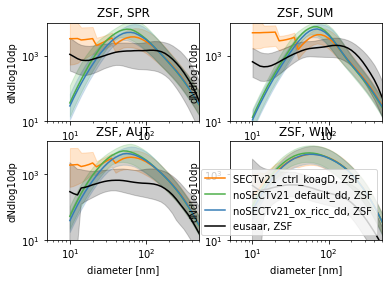

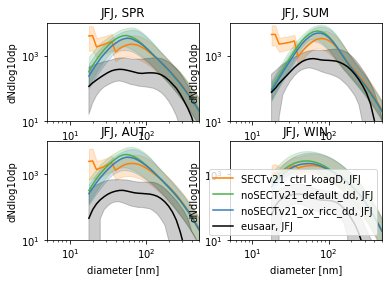

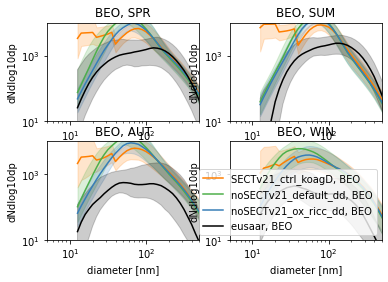

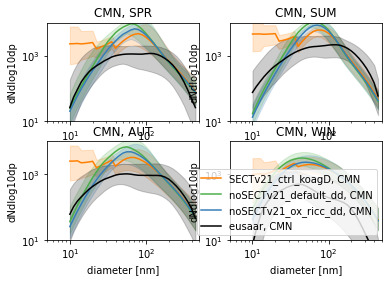

In [36]:
from sectional_v2.constants import collocate_locations
station='ASP'
colors_source = get_cmap_dic(dic_finish.keys())
colors_source['EUSAAR']='k'
for station in dic_finish[cases[0]].coords['station'].values:
    fig, axs = plt.subplots(2,2)
    seasons = ['SPR', 'SUM','AUT','WIN']
    for seas, ax in zip(seasons, axs.flatten()):
        for key in dic_finish.keys():
            plt_median_perc(dic_clean[key]['dNdlog10dp'], station, key,
                            color=get_case_col(key),
                            ax=ax,
                            subs=seas, percs=[16,84], yscale='log', ylim=[10,1e4])
            ax.set_title(station+', '+ seas)


    plt.legend()
    plt.show()

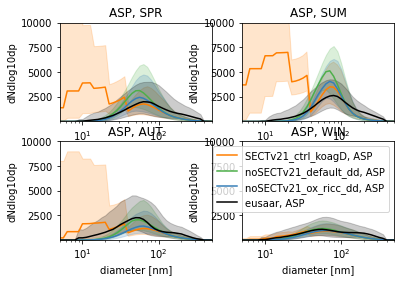

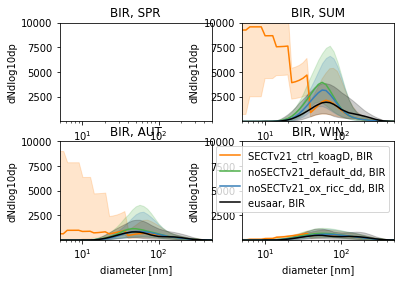

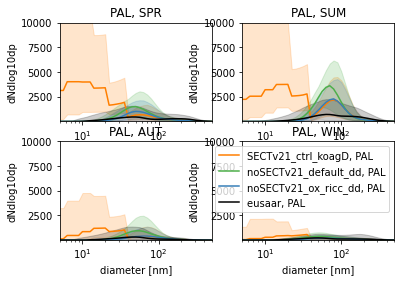

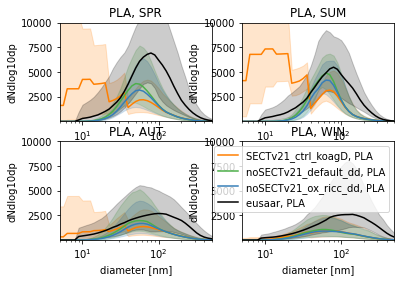

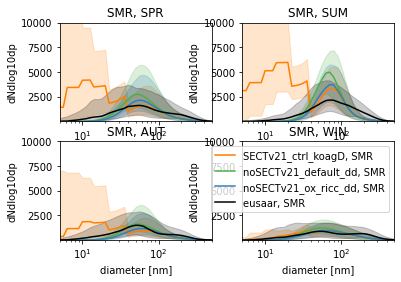

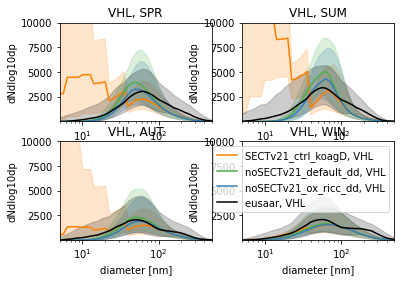

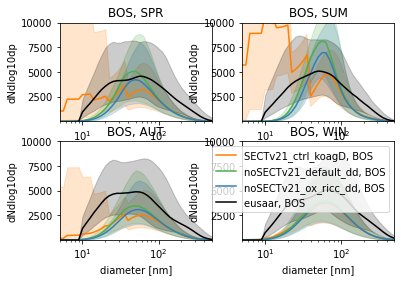

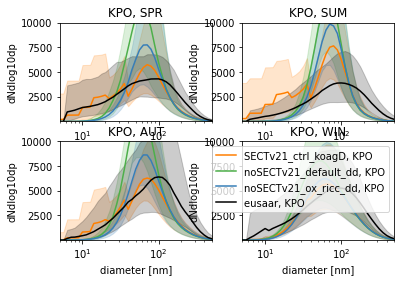

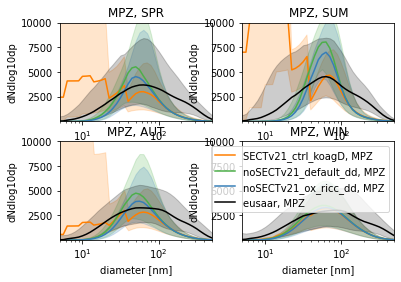

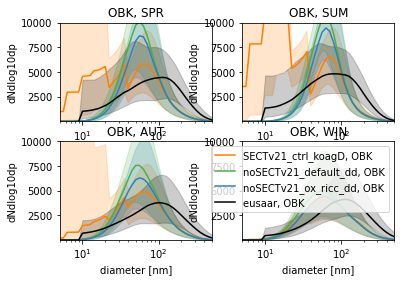

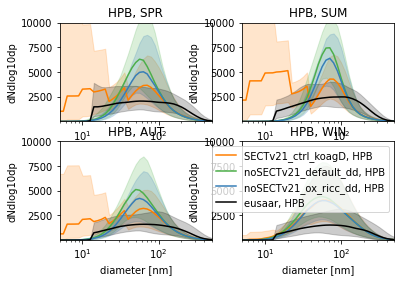

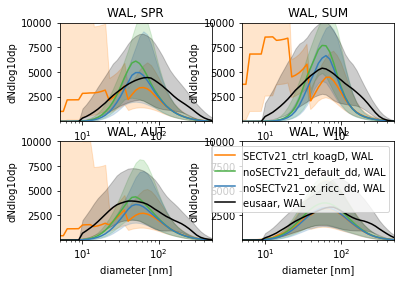

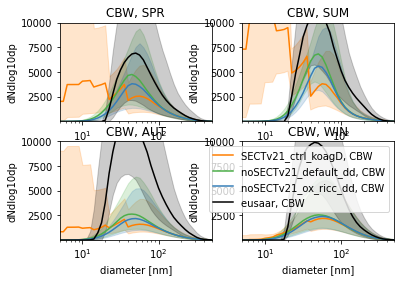

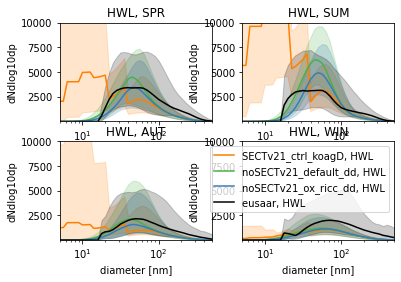

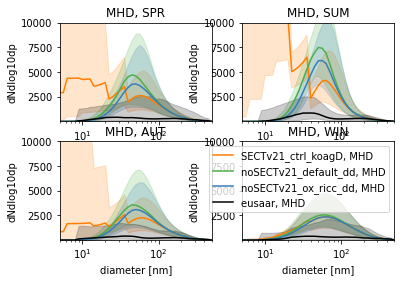

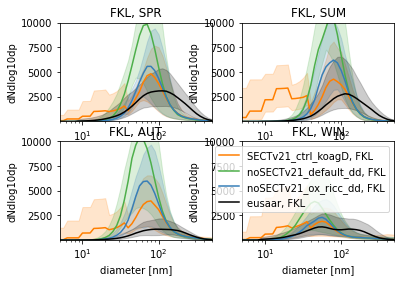

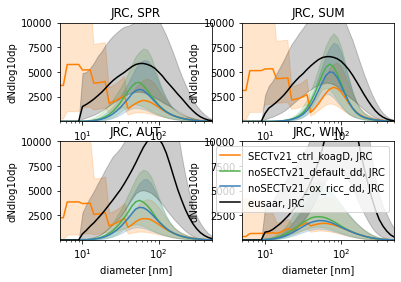

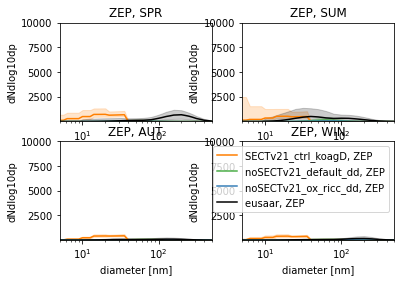

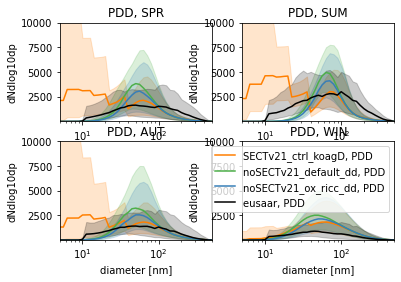

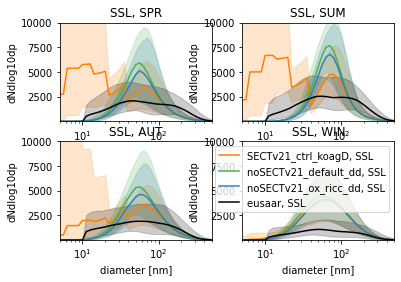

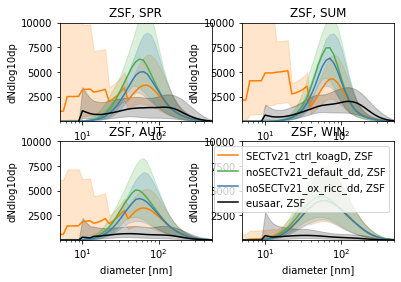

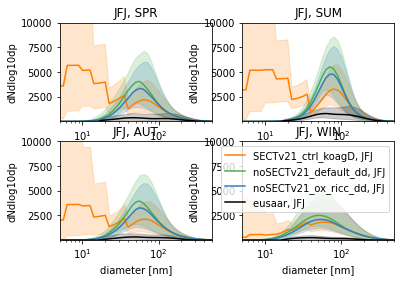

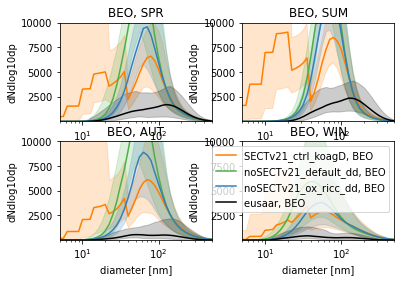

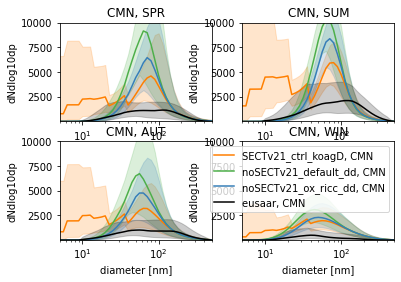

In [37]:
from sectional_v2.constants import collocate_locations
station='ASP'
colors_source = get_cmap_dic(dic_finish.keys())
colors_source['EUSAAR']='k'
for station in dic_finish[cases[0]].coords['station'].values:
    fig, axs = plt.subplots(2,2)
    seasons = ['SPR', 'SUM','AUT','WIN']
    for seas, ax in zip(seasons, axs.flatten()):
        for key in dic_finish.keys():
            plt_median_perc(dic_finish[key]['dNdlog10dp'], station, key,
                            color=get_case_col(key),
                            ax=ax,
                            subs=seas, percs=[16,84], yscale='linear', ylim=[10,1e4])
            ax.set_title(station+', '+ seas)


    plt.legend()

    plt.show()

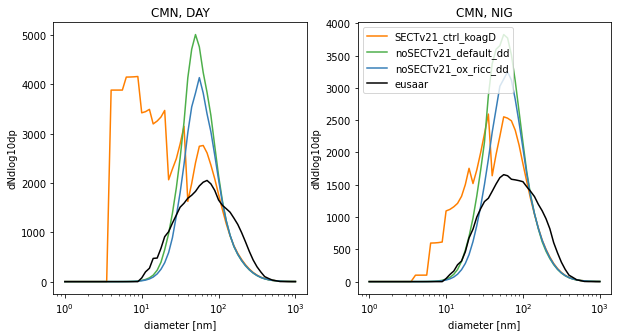

In [38]:
#for station in dic_finish[cases[0]].coords['station'].values:
fig, axs = plt.subplots(1,2, figsize=[10,5])
period = ['DAY', 'NIG']
for seas, ax in zip(period, axs.flatten()):
    for key in dic_finish.keys():
        dic_finish[key]['dNdlog10dp'].median('station').sel(subset=seas, percentile='50th percentile').plot(color=get_case_col(key), xscale='log', ax=ax, label=key)
        #plt_median_perc(dic_finish[key]['dNdlog10dp'], station, key,
        #                color=get_case_col(key),
        #                ax=ax,
        #                subs=seas, percs=[16,84], yscale='linear')
        ax.set_title(station+', '+ seas)

plt.legend()

plt.show()

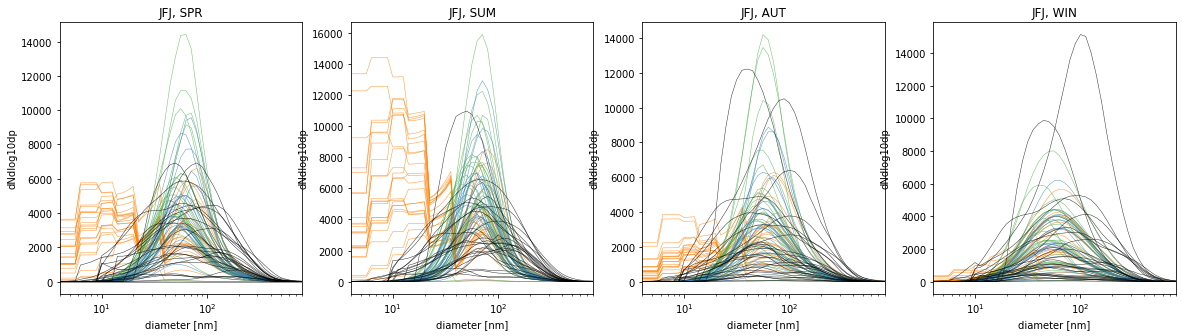

In [39]:
#for station in dic_finish[cases[0]].coords['station'].values:
fig, axs = plt.subplots(1,4, figsize=[20,5])
period = seasons
for seas, ax in zip(period, axs.flatten()):
    for key in dic_finish.keys():
        for station in dic_finish[key].station.values:
            _plt_da=dic_finish[key]['dNdlog10dp'].sel(subset=seas,station=station, percentile='50th percentile')#
            _plt_da.plot(color=get_case_col(key), xscale='log', ax=ax, label=key,
                        linewidth=.5, alpha=.8)
        #plt_median_perc(dic_finish[key]['dNdlog10dp'], station, key,
        #                color=get_case_col(key),
        #                ax=ax,
        #                subs=seas, percs=[16,84], yscale='linear')
        ax.set_title(station+', '+ seas)
        ax.set_xlim([4,800])

#plt.legend()

plt.show()

ASP


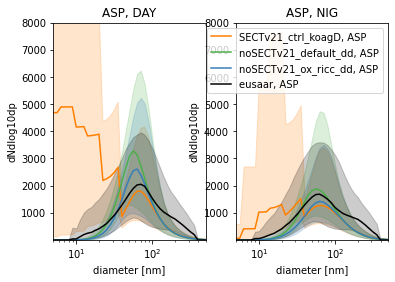

BIR


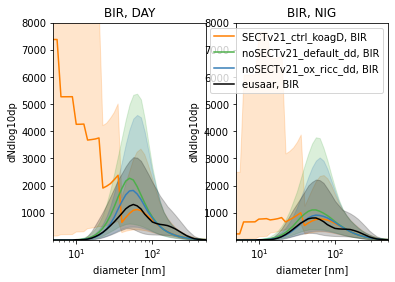

PAL


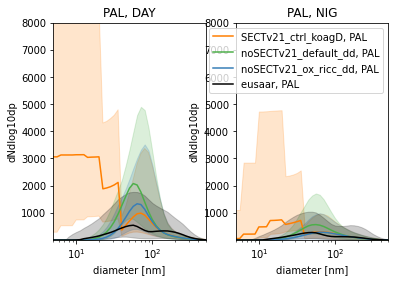

PLA


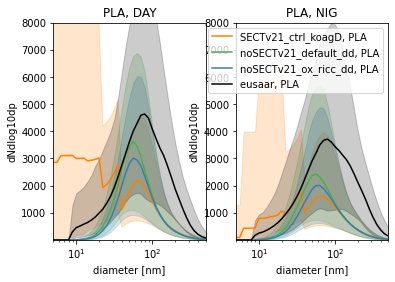

SMR


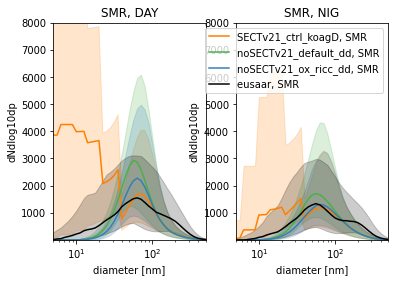

VHL


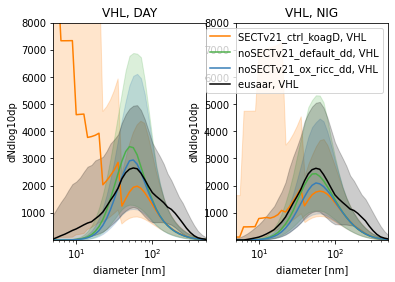

BOS


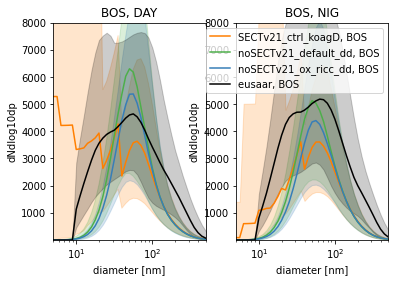

KPO


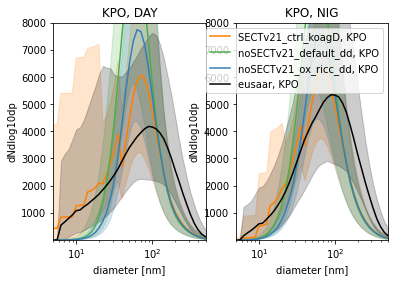

MPZ


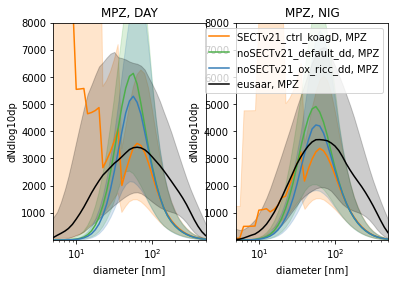

OBK


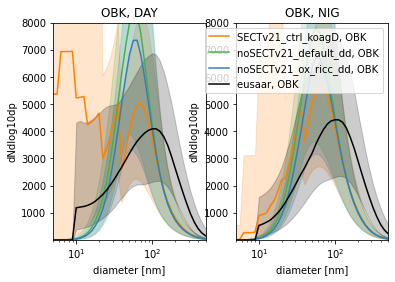

HPB


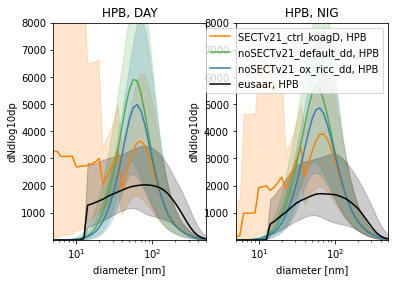

WAL


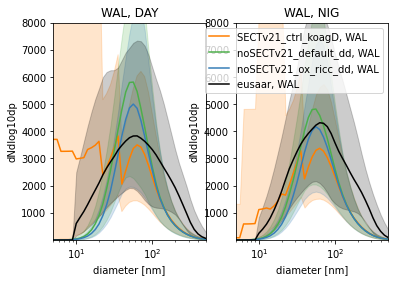

CBW


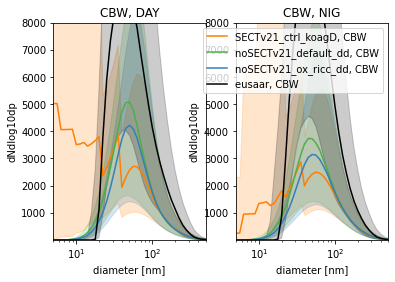

HWL


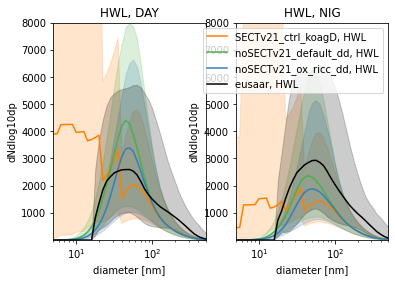

MHD


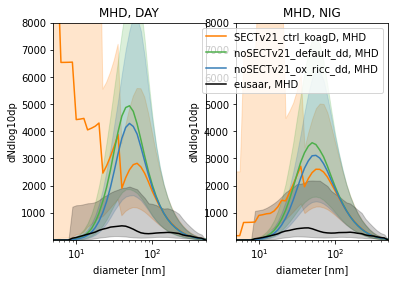

FKL


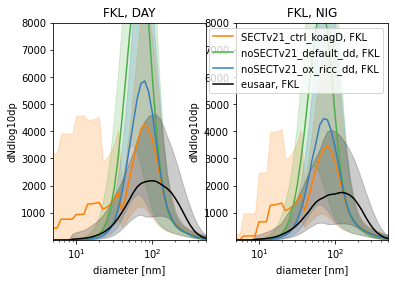

JRC


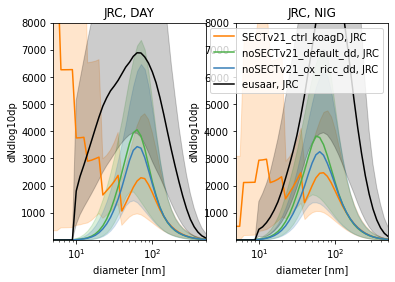

ZEP


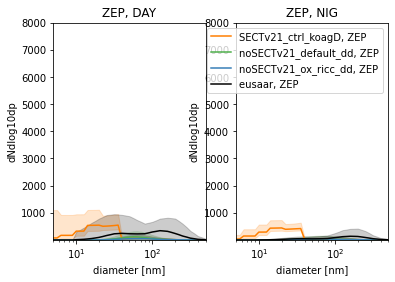

PDD


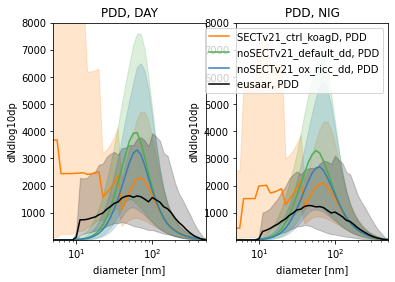

SSL


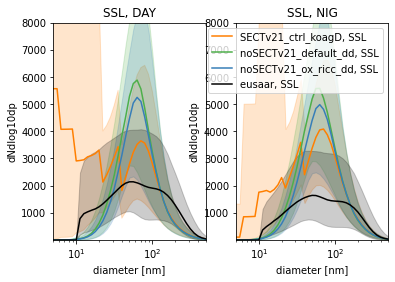

ZSF


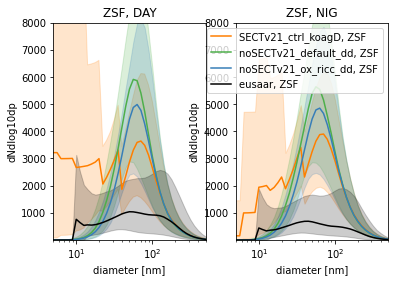

JFJ


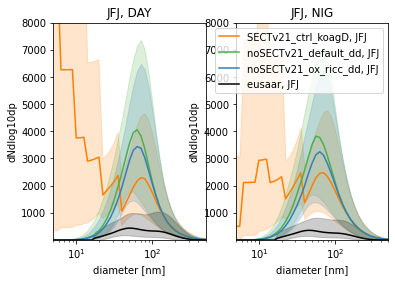

BEO


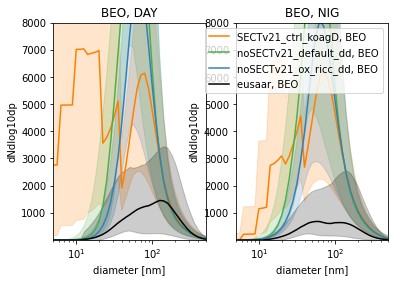

CMN


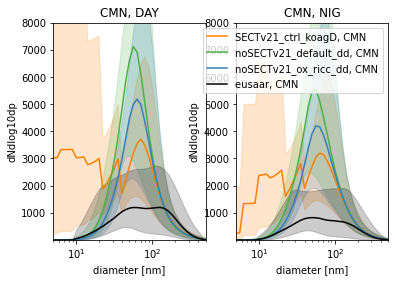

In [40]:
for station in dic_finish[cases[0]].coords['station'].values:
    print(station)
    fig, axs = plt.subplots(1,2)

    period = ['DAY', 'NIG']
    for seas, ax in zip(period, axs.flatten()):
        for key in dic_finish.keys():
            plt_median_perc(dic_finish[key]['dNdlog10dp'], station, key,
                            color=get_case_col(key),
                            ax=ax,
                            subs=seas, percs=[16,84], yscale='linear')
            ax.set_title(station+', '+ seas)


    plt.legend()
    plt.show()